In [63]:
import torch
import torch.nn.functional as F
from task.TaskGenerator import SinTaskGenerator
import matplotlib.pyplot as plt
from network.regressors_network import RegressorNetwork
from learner.MetaLearner import RegressorMAML

In [64]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.enc1 = torch.nn.Linear(3, 32) # 3 input: x, f_t(x), f_(t-1)(x)
        self.enc2 = torch.nn.GRU(input_size=32, hidden_size=16, num_layers=3, batch_first=True)
        self.enc3 = torch.nn.Linear(16, 16)
        self.enc4 = torch.nn.Linear(16, 3)
        
    def encode(self, context):
        n_batch = context.shape[0]
        seq_len = context.shape[1]
        t = F.elu(self.enc1(context)).view(n_batch, seq_len, 32)
        t = self.enc2(t)[0][:, -1, :] # we are interested only in the last output of the sequence
        t = F.elu(t)
        t = F.elu(self.enc3(t))
        return  self.enc4(t)
        
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, context):
        return self.encode(context)

In [65]:
model = Model()
optimizer = torch.optim.Adam(model.parameters())

In [66]:
def loss_function(recon_f, f):
    MSE = F.mse_loss(recon_f, f)
    #KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return MSE 

In [67]:
task_gen = SinTaskGenerator(x_min=-5, x_max=5)
dataset = []

# Task parameters range
max_a = 0.1
min_a = 10

min_phase = -2
max_phase = 2

min_freq = 0.1
max_freq = 10

def sample_task(n_batches=10, test_perc=0, batch_size=128):
    a = (min_a - max_a) * torch.rand(1) + max_a
    phase = (min_phase - max_phase) * torch.rand(1) + max_phase
    f = (min_freq - max_freq) * torch.rand(1) + max_freq
    
    """
    a_t2 = a_t1 + torch.rand(1) * offset_a_max
    phase_t2 = phase_t1 + torch.rand(1) * offset_phase_max
    f_t2 = f_t1 + torch.rand(1) * offset_f_max
    """
    data = task_gen.get_data_loader(amplitude=a, 
                                    phase=phase,
                                    frequency=f,
                                    num_batches=n_batches,
                                    test_perc=test_perc, 
                                    batch_size=batch_size)

    return data, a, phase, f

# Dataset creation
n_tasks = 1000
data_set = []
a_set = []
phase_set = []
f_set = []
param = []
for _ in range(n_tasks):
    data, a, phase, f = sample_task(n_batches=1, test_perc=0, batch_size=128)
    data_set.append(data)
    a_set.append(a)
    phase_set.append(phase)
    f_set.append(f)
    param.append((a.item(), phase.item(), f.item()))

In [68]:
offset = 2

def batch_train_offset(epoch, n_batch=10):
    train_loss = 0
    n_batch = 32
    batch_per_task = 1
    task_idx = torch.randint(low=0, high=n_tasks, size=(n_batch,))
    task_loader = [data_set[i] for i in task_idx]
    curr_param = [param[i] for i in task_idx]

    for k in range(batch_per_task):
        num_data_context = torch.randint(low=5, high=25, size=(1,)).item()
        idx = torch.randint(0, 128, (128,))
        ctx_idx = idx[0:num_data_context]
        
        context = torch.empty(n_batch, num_data_context, 3)
        target = torch.empty(n_batch, 3)

        # Retrieving data to be fed to the network 
        i = 0
        for t_idx, task in enumerate(task_loader):
            # Creating new task
            a_offset = torch.rand(1) * offset
            p_offset = torch.rand(1) * offset
            f_offset = torch.rand(1) * offset
            offset_param = torch.Tensor([a_offset, p_offset, f_offset])
            target[i] = offset_param

            # Creating context to be fed to the network 
            batch = task[k]['train']
            x = batch[0]
            task_pred = (curr_param[t_idx][0]+a_offset) * torch.sin((curr_param[t_idx][2]+f_offset)*x+(curr_param[t_idx][1]+p_offset))
            batch = torch.cat([batch[0], batch[1], task_pred], dim=1)
            context[i] = batch[ctx_idx]
            i+=1

        optimizer.zero_grad()
        z_hat = model(context)

        # Compute reconstruction
        loss = loss_function(z_hat, target)
        loss.backward()

        train_loss += loss.item()
        optimizer.step()
    
    return train_loss / (batch_per_task)



def batch_train(epoch, n_batch=10):
    train_loss = 0
    n_batch = 32
    batch_per_task = 1
    task_idx = torch.randint(low=0, high=n_tasks, size=(n_batch,))
    task_loader = [data_set[i] for i in task_idx]
    curr_param = [param[i] for i in task_idx]

    for k in range(batch_per_task):
        num_data_context = torch.randint(low=5, high=25, size=(1,)).item()
        idx = torch.randint(0, 128, (128,))
        ctx_idx = idx[0:num_data_context]
        
        context = torch.empty(n_batch, num_data_context, 3)
        target = torch.empty(n_batch, 3)

        # Retrieving data to be fed to the network 
        i = 0
        for t_idx, task in enumerate(task_loader):
            # Creating new task
            a_offset = torch.rand(1) * offset
            p_offset = torch.rand(1) * offset
            f_offset = torch.rand(1) * offset
            offset_param = torch.Tensor([curr_param[t_idx][0]+a_offset
                                         ,curr_param[t_idx][1]+p_offset, curr_param[t_idx][2]+f_offset])
            target[i] = offset_param

            # Creating context to be fed to the network 
            batch = task[k]['train']
            x = batch[0]
            task_pred = (curr_param[t_idx][0]+a_offset) * torch.sin((curr_param[t_idx][2]+f_offset)*x+(curr_param[t_idx][1]+p_offset))
            batch = torch.cat([batch[0], batch[1], task_pred], dim=1)
            context[i] = batch[ctx_idx]
            i+=1

        optimizer.zero_grad()
        z_hat = model(context)
        print(target)
        print(z_hat)

        # Compute reconstruction
        loss = loss_function(z_hat, target)
        loss.backward()

        train_loss += loss.item()
        optimizer.step()
    
    return train_loss / (batch_per_task)

In [69]:
n_epochs = 20000
losses = []
l_sum = 0
for i in range(n_epochs):
    l = batch_train_offset(i)
    l_sum += l
    losses.append(l)
    if i % 100 == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(i, l_sum/(i+1)))

====> Epoch: 0 Average loss: 1.0886
====> Epoch: 100 Average loss: 0.4665
====> Epoch: 200 Average loss: 0.3976
====> Epoch: 300 Average loss: 0.3755
====> Epoch: 400 Average loss: 0.3633
====> Epoch: 500 Average loss: 0.3547
====> Epoch: 600 Average loss: 0.3465
====> Epoch: 700 Average loss: 0.3411
====> Epoch: 800 Average loss: 0.3361
====> Epoch: 900 Average loss: 0.3324
====> Epoch: 1000 Average loss: 0.3287
====> Epoch: 1100 Average loss: 0.3257
====> Epoch: 1200 Average loss: 0.3233
====> Epoch: 1300 Average loss: 0.3206
====> Epoch: 1400 Average loss: 0.3181
====> Epoch: 1500 Average loss: 0.3161
====> Epoch: 1600 Average loss: 0.3141
====> Epoch: 1700 Average loss: 0.3127
====> Epoch: 1800 Average loss: 0.3112
====> Epoch: 1900 Average loss: 0.3095
====> Epoch: 2000 Average loss: 0.3082
====> Epoch: 2100 Average loss: 0.3070
====> Epoch: 2200 Average loss: 0.3060
====> Epoch: 2300 Average loss: 0.3048
====> Epoch: 2400 Average loss: 0.3037
====> Epoch: 2500 Average loss: 0.302

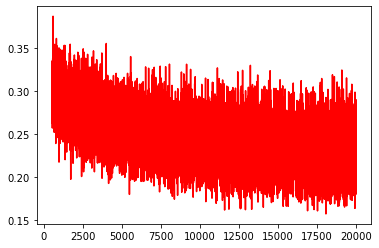

In [70]:
import numpy as np
from scipy.signal import savgol_filter
y = np.array(losses)
x = np.arange(len(y))
yhat = savgol_filter(y,5, 3) 

plt.plot(x[500:], yhat[500:], color='red')
plt.show()

In [51]:
y[17500:].max()

0.40747663378715515

# Just an example of how we should transform things

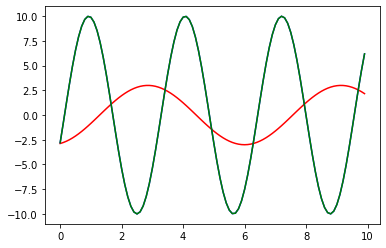

In [52]:
"""
g(zy+d)=a*f(w(zx+d)+phi) = a * f(wzy+wd+phi) -> d = phi/w
E poi shift sul coefficente moltiplicativo

Ora ho tutto per generare la sequenza di sinusoidi dato lo spazio latente di shifting e l'accesso alla
funzione precedente
new_x = f_1 * x + ((phi_1-phi_0)/f_0)
g_1 = (a_1/a_0) * g_0(new_x) 
"""
p_0 = 5
f_0 = 1
a_0 = 3

p_1 = 6
f_1 = 2
a_1 = 10

def foo(x):
    return a_0*torch.sin(f_0*x+p_0)

def foo_2(x):
    return a_1*torch.sin(f_1*x+p_1)

x_space = torch.arange(0, 10, 0.1)

f_original = foo(x_space)
f_target = foo_2(x_space)

new_space = f_1*x_space+((p_1-p_0)/f_0)
new_f = (a_1/a_0)*foo(new_space)

plt.plot(x_space, f_original, color='red')
plt.plot(x_space, f_target, color='blue')
plt.plot(x_space, new_f, color='green')
plt.show()

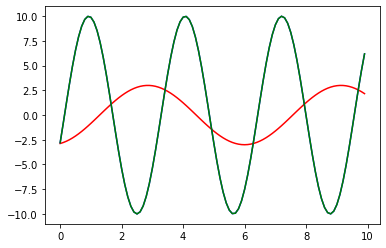

In [53]:
"""
g(zy+d)=a*f(w(zx+d)+phi) = a * f(wzy+wd+phi) -> d = phi/w
E poi shift sul coefficente moltiplicativo

Ora ho tutto per generare la sequenza di sinusoidi dato lo spazio latente di shifting e l'accesso alla
funzione precedente
new_x = f_1 * x + ((phi_1-phi_0)/f_0)
g_1 = (a_1/a_0) * g_0(new_x) 
"""
p_0 = 5
f_0 = 1
a_0 = 3

p_1 = 6
f_1 = 2
a_1 = 10

off_p = p_1 - p_0 
off_f = f_1 - f_0
off_a = a_1 - a_0

def foo(x):
    return a_0*torch.sin(f_0*x+p_0)

def foo_2(x):
    return a_1*torch.sin(f_1*x+p_1)

x_space = torch.arange(0, 10, 0.1)

f_original = foo(x_space)
f_target = foo_2(x_space)

new_space = (f_0+off_f)*x_space+((off_p)/f_0)
new_f = ((a_0+off_a)/a_0)*foo(new_space)

plt.plot(x_space, f_original, color='red')
plt.plot(x_space, f_target, color='blue')
plt.plot(x_space, new_f, color='green')
plt.show()

# Now... Let's switch to the sequential setting

In [54]:
class NewNetwork(torch.nn.Module):

    def __init__(self, input_size, output_size, hidden_size):
        super(NewNetwork, self).__init__()
        self.layer_1 = torch.nn.Linear(input_size, hidden_size)
        self.layer_2 = torch.nn.Linear(hidden_size, hidden_size)
        self.layer_3 = torch.nn.Linear(hidden_size, hidden_size)
        self.layer_4 = torch.nn.Linear(hidden_size, hidden_size)
        self.layer_5 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.layer_1(x))
        x = torch.relu(self.layer_2(x))
        x = torch.relu(self.layer_3(x))
        x = torch.relu(self.layer_4(x))
        x = self.layer_5(x)
        return x

class VaeMAML(RegressorMAML):

    def __init__(self, network, vae_model, x_space, n_hallucination=15,
                 n_batch_hallucination=5,
                 device="cpu", step_size=0.5, first_order=False,
                 optimizer=None, learn_step_size=False, per_param_step_size=False,
                 num_adaptation_step=1, scheduler=None, loss_function=F.mse_loss):
        super(VaeMAML, self).__init__(network,
                                      device=device,
                                      step_size=step_size,
                                      first_order=first_order,
                                      optimizer=optimizer,
                                      learn_step_size=learn_step_size,
                                      per_param_step_size=per_param_step_size,
                                      num_adaptation_step=num_adaptation_step,
                                      scheduler=scheduler,
                                      loss_function=loss_function)
        self.vae_model = vae_model
        self.x_space = x_space
        self.n_hallucination = n_hallucination
        self.n_batch_hallucination = n_batch_hallucination
        self.curr_z = None
        
    def init_learner(self, data_loader, max_batches, init_z, verbose=True):
        # Train the learner on the given dataset
        self.train(data_loader=data_loader, max_batches=max_batches, verbose=verbose)
        
        # Store the latent space of the learner
        self.curr_z = init_z

    def meta_testing(self, data):
        """
        During meta testing:
        - Analyze the current data used with VAE in order to infer the latent parameters
        - Use the current network and the inferred parameter in order to generate data for the adaptation
        - Adapt the model
        """
        # Enhance dataset
        # TODO
        
        # Analyze the current data with VAE to infer the latent parameters
        z = self.vae_model(self.network, data)

        # Use the current network and the inferred parameters in order to generate data for adaptation
        hallucinated_dataset = []
        for b in range(self.n_batch_hallucination):
            new_idx = torch.randint(low=0, high=self.x_space[-1], size=(self.n_hallucination,))
            new_x = self.x_space[new_idx]
            new_t = z[0] * self.network(z[1] * new_x - z[2])
            hallucinated_dataset.append([new_x, new_t])

        # Adapt the model using the new dataset
        optim = torch.optim.SGD(self.network.parameters(), lr=self.step_size, momentum=0.)

        for batch in hallucinated_dataset:
            batch = tensors_to_device(batch, device=self.device)

            for i in range(self.num_adaptation_steps):
                inputs = batch[0]
                target = batch[1]
                optim.zero_grad()
                pred = self.network(inputs)
                loss = self.loss_function(pred, target)
                loss.backward()
                optim.step()

In [55]:
# Create the learner
network = NewNetwork(input_size=1, output_size=1, hidden_size=64)
loss_learner = torch.nn.MSELoss()
optimizer_learner = torch.optim.Adam(network.parameters(), lr=0.01)
x_space = task_gen.x_space

learner = VaeMAML(network=network, vae_model=model, x_space=x_space, n_hallucination=15,
                  n_batch_hallucination=5,
                  device="cpu", step_size=0.5, first_order=False,
                  optimizer=optimizer_learner, learn_step_size=False, per_param_step_size=False,
                  num_adaptation_step=1, scheduler=None, loss_function=loss_learner)

In [56]:
# Now that we learnt the first task, we should give the learner a sequence of tasks to see how it reacts 
# and how it adapts to the goal 
AMPLITUDE_LIST = [1, 1.4, 1.8, 2.2, 2.8, 3.2, 3.6, 4.0, 4.4, 4.0, 3.6, 3.2, 3.6, 3.2, 3.2, 2.8]
PHASE_LIST = [0, 0.3, 0.6, 0.8, 1.0, 1.3, 1.6, 1.3, 1.6, 1.3, 1.0, 1.5, 1.8, 1.4, 1.5, 1.3]
F_LIST = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# First task
init_z = torch.Tensor([AMPLITUDE_LIST[0], PHASE_LIST[0], F_LIST[0]])
data_loader_task_0 = task_gen.get_data_loader(amplitude=AMPLITUDE_LIST[0], test_perc=0,phase=PHASE_LIST[0], num_batches=3000, batch_size=128)
learner.init_learner(data_loader_task_0, 5000, init_z)

5001it [00:35, 140.15it/s, loss=0.0129]                          


In [80]:
# Now we have the first task
data_first_task = task_gen.get_data_loader(amplitude=AMPLITUDE_LIST[1], test_perc=0, phase=PHASE_LIST[1], num_batches=1, batch_size=128)

# Now we have to reshape the data to use the VAE network
batch = data_first_task[0]['train']
x = batch[0]
old_pred = learner.network(x)
batch = torch.cat([batch[0], old_pred, batch[1]], dim=1)
batch.shape

torch.Size([128, 3])

In [81]:
z_inferred = model(batch.unsqueeze(0))
z_inferred

tensor([[0.3072, 1.0353, 0.1823]], grad_fn=<AddmmBackward>)

In [82]:
z_0 = torch.tensor([1., 0., 1.])
z = z_0+z_inferred
z = z.detach()

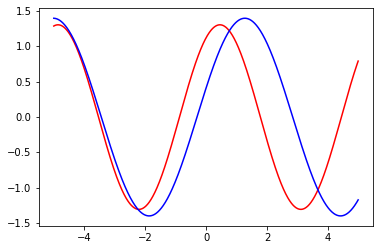

In [83]:
plt.plot(x_space[0], torch.sin(x_space[0] * z[0, 2] + z[0,1]) * z[0,0], color="red")
plt.plot(x_space[0], torch.sin(x_space[0] * F_LIST[1] + PHASE_LIST[1]) * AMPLITUDE_LIST[1], color="blue")

In [79]:
data_first_task[0]['train'][0]

tensor([[ 4.5500],
        [ 3.2000],
        [-0.7000],
        [ 2.7600],
        [-3.9500],
        [ 4.2800],
        [ 1.1600],
        [ 2.8100],
        [ 2.9700],
        [-2.1600],
        [-1.5800],
        [ 0.0600],
        [-3.3100],
        [ 4.0700],
        [-4.5300],
        [ 4.7700],
        [-2.8100],
        [ 1.2800],
        [ 4.8100],
        [-1.2600]])